# 과제2 : 배송 성과 분석 및 지역별 물류 최적화 방안
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요.

In [ ]:
# ============================================================
# 배송 성과 분석 & 지역별 물류 최적화 방안
# 1. 주문~배송 소요시간 분석
# 2. 지역별(주/권역) 배송 성과 차이 파악
# 3. 물류 최적화 방안 도출
# 4. 배송 지연이 리뷰 점수에 미치는 영향 분석
# ============================================================

=== (1) 전체 리드타임/지연 요약 ===


,count,리드타임_평균(일),리드타임_중위(일),리드타임_p90(일),지연_평균(일),정시율(%)
0,96470,12.56,10.22,23.10,-11.18,91.89


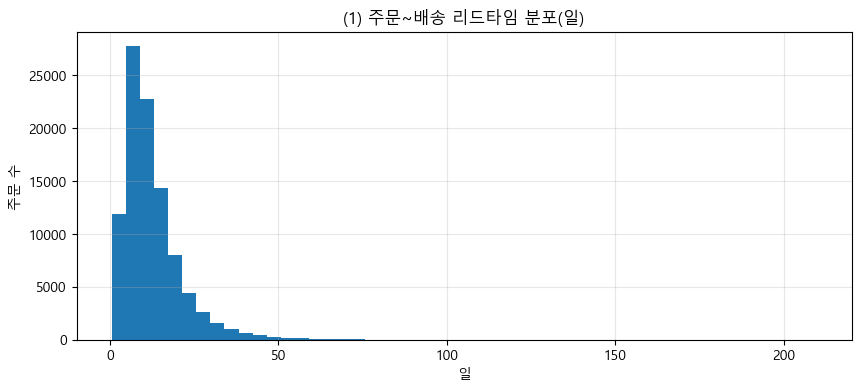

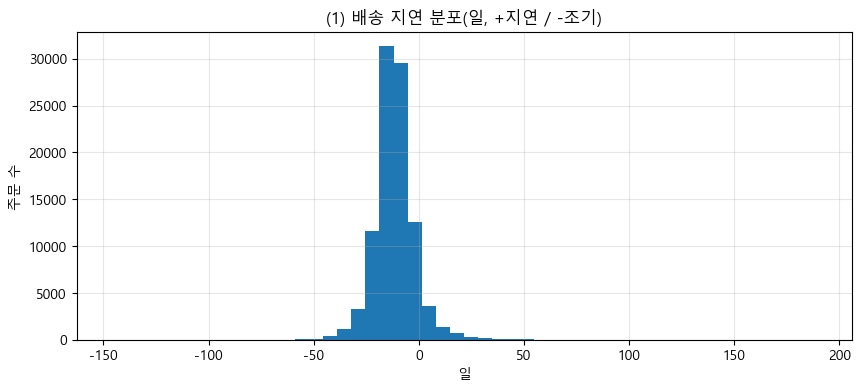

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.float_format = lambda x: f"{x:,.2f}"

# -----------------------------
# 0) 데이터 불러오기
# -----------------------------

customers = pd.read_csv('./olist_customers_dataset.csv')        # 고객
orders    = pd.read_csv('./olist_orders_dataset.csv')           # 주문
payments  = pd.read_csv('./olist_order_payments_dataset.csv')   # 결제
reviews   = pd.read_csv('./olist_order_reviews_dataset.csv')    # 리뷰
sellers   = pd.read_csv('./olist_sellers_dataset.csv')          # 셀러
items     = pd.read_csv('./olist_order_items_dataset.csv')      # 주문상품
products  = pd.read_csv('./olist_products_dataset.csv')         # 상품
geoloc    = pd.read_csv('./olist_geolocation_dataset.csv')      # 위치
category  = pd.read_csv('./product_category_name_translation.csv') # 카테고리

# 날짜 변환
dt_cols = [
    'order_purchase_timestamp','order_approved_at',
    'order_delivered_carrier_date','order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for c in dt_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')

# 배송 완료 주문만 사용(핵심 분석 지표의 신뢰성 확보)
delivered = orders[(orders['order_status'] == 'delivered') & orders['order_delivered_customer_date'].notna()].copy()

# 고객/판매자 지역 정보 병합(주: UF 코드)
delivered = delivered.merge(customers[['customer_id','customer_unique_id','customer_state']],
                            on='customer_id', how='left')
# 주문-아이템-판매자 연결(다-대 관계: 주문별 다수 판매자 가능 → 아이템 단위 분석용도)
items_seller = items.merge(sellers[['seller_id','seller_state']], on='seller_id', how='left')

# 브라질 권역 매핑
uf_to_region = {
    # North
    "AC":"North","AP":"North","AM":"North","PA":"North","RO":"North","RR":"North","TO":"North",
    # Northeast
    "AL":"Northeast","BA":"Northeast","CE":"Northeast","MA":"Northeast","PB":"Northeast",
    "PE":"Northeast","PI":"Northeast","RN":"Northeast","SE":"Northeast",
    # Central-West
    "DF":"Central-West","GO":"Central-West","MT":"Central-West","MS":"Central-West",
    # Southeast
    "ES":"Southeast","MG":"Southeast","RJ":"Southeast","SP":"Southeast",
    # South
    "PR":"South","RS":"South","SC":"South"
}
delivered['customer_region'] = delivered['customer_state'].map(uf_to_region)
sellers['seller_region'] = sellers['seller_state'].map(uf_to_region)

# -------------------------------------------------
# (1) 주문부터 배송 완료까지의 시간을 분석 (리드타임)
# -------------------------------------------------
ship = delivered.copy()

# 구간별 소요 시간(일)
ship['t_purchase_to_approved'] = (ship['order_approved_at'] - ship['order_purchase_timestamp']).dt.total_seconds() / 86400
ship['t_approved_to_carrier']  = (ship['order_delivered_carrier_date'] - ship['order_approved_at']).dt.total_seconds() / 86400
ship['t_carrier_to_customer']  = (ship['order_delivered_customer_date'] - ship['order_delivered_carrier_date']).dt.total_seconds() / 86400
ship['t_purchase_to_delivered']= (ship['order_delivered_customer_date'] - ship['order_purchase_timestamp']).dt.total_seconds() / 86400
ship['t_purchase_to_estimated']= (ship['order_estimated_delivery_date'] - ship['order_purchase_timestamp']).dt.total_seconds() / 86400

# 지연(+) / 조기(-)
ship['delay_days'] = (ship['order_delivered_customer_date'] - ship['order_estimated_delivery_date']).dt.total_seconds() / 86400

# 핵심 지표 요약
def pct(s, q): 
    return np.nanpercentile(s, q)
summary_overall = pd.DataFrame({
    'count':[len(ship)],
    '리드타임_평균(일)':[ship['t_purchase_to_delivered'].mean()],
    '리드타임_중위(일)':[ship['t_purchase_to_delivered'].median()],
    '리드타임_p90(일)':[pct(ship['t_purchase_to_delivered'],90)],
    '지연_평균(일)':[ship['delay_days'].mean()],
    '정시율(%)':[(ship['delay_days']<=0).mean()*100]
})
print("=== (1) 전체 리드타임/지연 요약 ===")
display(summary_overall.round(2))

# 시각화: 리드타임 분포 & 지연 분포
plt.figure(figsize=(10,4))
plt.hist(ship['t_purchase_to_delivered'].dropna(), bins=50)
plt.title("(1) 주문~배송 리드타임 분포(일)")
plt.xlabel("일"); plt.ylabel("주문 수")
plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(10,4))
plt.hist(ship['delay_days'].dropna(), bins=50)
plt.title("(1) 배송 지연 분포(일, +지연 / -조기)")
plt.xlabel("일"); plt.ylabel("주문 수")
plt.grid(alpha=0.3); plt.show()


=== (2) 주(State) 단위 성과 ===


,customer_state,주문수,리드타임_평균,리드타임_중위,p90,지연_평균,정시율
0,RO,243,19.37,17.58,29.53,-19.40,97.12
1,AC,80,21.04,18.36,31.08,-20.08,96.25
2,AM,145,26.43,25.88,39.13,-18.85,95.86
3,AP,67,27.19,24.35,34.66,-19.06,95.52
4,PR,4923,11.99,10.43,20.12,-12.62,95.00
5,MG,11354,12.01,10.31,20.20,-12.54,94.39
6,SP,40494,8.76,7.21,15.77,-10.38,94.11
7,MT,886,18.06,16.11,27.76,-13.69,93.23
8,DF,2080,12.97,11.36,21.64,-11.34,92.93
9,RS,5344,15.30,13.18,25.88,-13.21,92.85


=== (2) 권역 단위 성과 ===


,customer_region,주문수,리드타임_평균,리드타임_중위,p90,지연_평균,정시율
0,Southeast,66193,10.75,8.71,19.62,-10.86,92.55
1,South,13813,14.03,12.12,24.03,-12.38,92.95
2,Central-West,5624,15.02,13.28,24.22,-11.64,92.03
3,Northeast,9044,20.01,17.32,33.11,-10.65,85.67
4,North,1796,22.59,20.16,36.56,-14.93,90.20


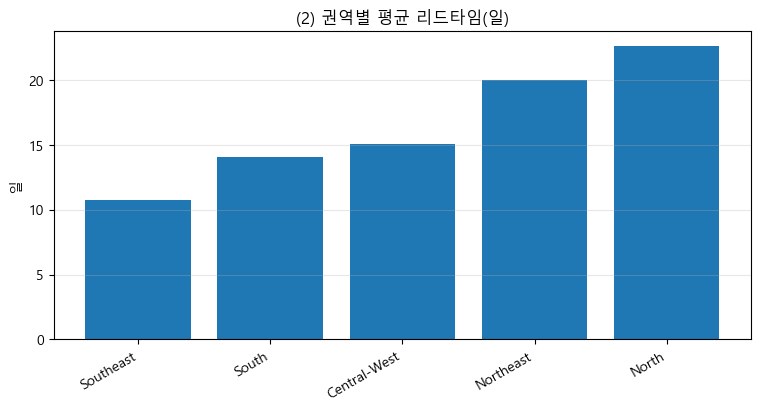

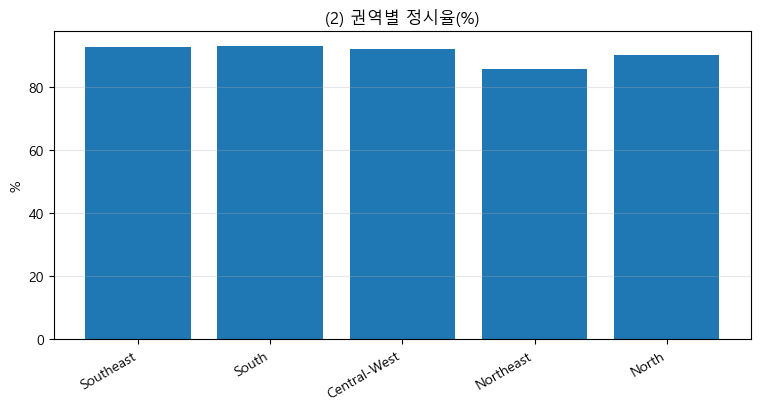

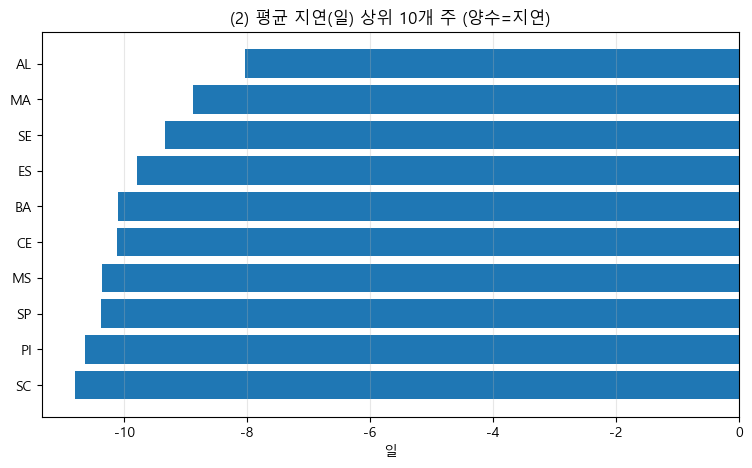

=== (2) 판매자주 → 고객주 코리도어 성과(상위 10개) ===


,seller_state,customer_state,주문수,리드타임_평균,지연_평균,정시율
249,PI,PI,1,2.03,-14.06,100.00
202,PA,PR,1,3.46,-14.10,100.00
310,RN,MG,1,3.56,-12.02,100.00
315,RN,RN,21,4.74,-14.87,100.00
245,PI,MA,1,5.84,-13.29,100.00
33,CE,CE,9,6.32,-15.77,100.00
215,PB,PE,2,6.72,-18.72,100.00
210,PB,MA,1,7.18,-31.29,100.00
206,PB,CE,2,7.51,-26.54,100.00
321,RO,PR,1,7.96,-23.47,100.00


In [8]:
# -------------------------------------------------
# (2) 지역별 배송 성과 차이 (주 & 권역)
# -------------------------------------------------
# 주(State) 단위
by_state = (ship
    .groupby('customer_state')
    .agg(주문수=('order_id','nunique'),
         리드타임_평균=('t_purchase_to_delivered','mean'),
         리드타임_중위=('t_purchase_to_delivered','median'),
         p90=('t_purchase_to_delivered', lambda s: pct(s,90)),
         지연_평균=('delay_days','mean'),
         정시율=('delay_days', lambda s: (s<=0).mean()*100))
    .sort_values(['정시율','리드타임_평균'], ascending=[False, True])
    .reset_index()
)
print("=== (2) 주(State) 단위 성과 ===")
display(by_state.round(2).head(10))

# 권역(Region) 단위
by_region = (ship
    .groupby('customer_region')
    .agg(주문수=('order_id','nunique'),
         리드타임_평균=('t_purchase_to_delivered','mean'),
         리드타임_중위=('t_purchase_to_delivered','median'),
         p90=('t_purchase_to_delivered', lambda s: pct(s,90)),
         지연_평균=('delay_days','mean'),
         정시율=('delay_days', lambda s: (s<=0).mean()*100))
    .sort_values('리드타임_평균')
    .reset_index()
)
print("=== (2) 권역 단위 성과 ===")
display(by_region.round(2))

# 시각화: 권역별 리드타임 & 정시율
plt.figure(figsize=(9,4))
plt.bar(by_region['customer_region'].astype(str), by_region['리드타임_평균'])
plt.title("(2) 권역별 평균 리드타임(일)")
plt.xticks(rotation=30, ha='right'); plt.ylabel("일"); plt.grid(axis='y', alpha=0.3); plt.show()

plt.figure(figsize=(9,4))
plt.bar(by_region['customer_region'].astype(str), by_region['정시율'])
plt.title("(2) 권역별 정시율(%)")
plt.xticks(rotation=30, ha='right'); plt.ylabel("%"); plt.grid(axis='y', alpha=0.3); plt.show()

# 주 단위: '지연_평균' 상위 10개(= 더 느린 지역)
worst_states = by_state.sort_values('지연_평균', ascending=False).head(10)
plt.figure(figsize=(9,5))
plt.barh(worst_states['customer_state'].astype(str), worst_states['지연_평균'])
plt.title("(2) 평균 지연(일) 상위 10개 주 (양수=지연)")
plt.xlabel("일"); plt.gca().invert_yaxis(); plt.grid(axis='x', alpha=0.3); plt.show()

# (선택) 판매자-고객 '주-주' 흐름(코리도어) 성과
# 아이템 단위로 주문-판매자-고객을 연결하여 코리도어별 리드타임/지연을 측정
item_order = items_seller.merge(delivered[['order_id','customer_state','customer_region',
                                           'order_purchase_timestamp','order_delivered_customer_date',
                                           'order_estimated_delivery_date']],
                                on='order_id', how='inner')
item_order['t_purchase_to_delivered'] = (item_order['order_delivered_customer_date'] - item_order['order_purchase_timestamp']).dt.total_seconds()/86400
item_order['delay_days'] = (item_order['order_delivered_customer_date'] - item_order['order_estimated_delivery_date']).dt.total_seconds()/86400
corridor = (item_order
    .groupby(['seller_state','customer_state'])
    .agg(주문수=('order_id','nunique'),
         리드타임_평균=('t_purchase_to_delivered','mean'),
         지연_평균=('delay_days','mean'),
         정시율=('delay_days', lambda s: (s<=0).mean()*100))
    .reset_index()
    .sort_values(['정시율','리드타임_평균'], ascending=[False, True])
)
print("=== (2) 판매자주 → 고객주 코리도어 성과(상위 10개) ===")
display(corridor.head(10).round(2))



In [9]:
# -------------------------------------------------
# (3) 물류 최적화 방안 도출 (데이터 기반 문구 자동 생성)
# -------------------------------------------------
# 데이터 포인트: 느린 권역/주, 지연 큰 코리도어, p90 높은 곳
slow_regions = by_region.sort_values('리드타임_평균', ascending=False).head(3)
risk_states  = by_state.sort_values('정시율').head(5)  # 정시율 낮은 주
slow_corr    = corridor.sort_values(['정시율','리드타임_평균'], ascending=[True, False]).head(5)

print("=== (3) 물류 최적화 제언 (데이터 기반) ===")
print("- 리드타임이 상대적으로 긴 권역 Top3:")
for _, r in slow_regions.iterrows():
    print(f"  • {r['customer_region']}: 평균 {r['리드타임_평균']:.2f}일, p90 {r['p90']:.2f}일, 정시율 {r['정시율']:.1f}%")

print("- 정시율이 낮은 주(개선 우선순위) Top5:")
for _, r in risk_states.iterrows():
    print(f"  • {r['customer_state']}: 정시율 {r['정시율']:.1f}%, 지연평균 {r['지연_평균']:.2f}일")

print("- 지연 성과가 나쁜 코리도어 Top5:")
for _, r in slow_corr.iterrows():
    print(f"  • {r['seller_state']} → {r['customer_state']}: 정시율 {r['정시율']:.1f}%, 리드타임평균 {r['리드타임_평균']:.2f}일, 지연평균 {r['지연_평균']:.2f}일")

print("\n[권역/주별 액션 가이드]")
print("1) Fulfillment 재배치/허브 최적화: 느린 권역·정시율 저조 주 인접에 마이크로-허브 및 풋프린트 확장 검토")
print("2) 라스트마일 SLA 재조정: 문제 코리도어(판매자주→고객주) 대상 운송사 SLA·리드타임 버퍼 재설계")
print("3) Line-haul 개선: 장거리/도서 지역에 대해 H-1 익일 출고, 합동 라우팅 및 적재율 최적화")
print("4) 재고 전진 배치: 수요 상위 SKU를 느린 권역 가까이 전진배치하여 t_approved_to_carrier 단축")
print("5) 예측 기반 약속일(EDD) 재산정: 지역·요일·시즌 성과 기반으로 개인화된 EDD 제공 → 지연 체감 감소")
print("6) 예외관리: 지연 가능성 높은 주문을 조기 탐지하여 고객 커뮤니케이션(알림/보상 쿠폰) 자동화")



=== (3) 물류 최적화 제언 (데이터 기반) ===
- 리드타임이 상대적으로 긴 권역 Top3:
  • North: 평균 22.59일, p90 36.56일, 정시율 90.2%
  • Northeast: 평균 20.01일, p90 33.11일, 정시율 85.7%
  • Central-West: 평균 15.02일, p90 24.22일, 정시율 92.0%
- 정시율이 낮은 주(개선 우선순위) Top5:
  • AL: 정시율 76.1%, 지연평균 -8.03일
  • MA: 정시율 80.3%, 지연평균 -8.89일
  • PI: 정시율 84.0%, 지연평균 -10.63일
  • CE: 정시율 84.7%, 지연평균 -10.11일
  • SE: 정시율 84.8%, 지연평균 -9.33일
- 지연 성과가 나쁜 코리도어 Top5:
  • CE → AM: 정시율 0.0%, 리드타임평균 138.88일, 지연평균 104.69일
  • AM → AL: 정시율 0.0%, 리드타임평균 90.96일, 지연평균 38.01일
  • BA → AC: 정시율 0.0%, 리드타임평균 66.95일, 지연평균 24.07일
  • PB → AL: 정시율 0.0%, 리드타임평균 31.10일, 지연평균 0.81일
  • AM → MA: 정시율 0.0%, 리드타임평균 29.52일, 지연평균 0.39일

[권역/주별 액션 가이드]
1) Fulfillment 재배치/허브 최적화: 느린 권역·정시율 저조 주 인접에 마이크로-허브 및 풋프린트 확장 검토
2) 라스트마일 SLA 재조정: 문제 코리도어(판매자주→고객주) 대상 운송사 SLA·리드타임 버퍼 재설계
3) Line-haul 개선: 장거리/도서 지역에 대해 H-1 익일 출고, 합동 라우팅 및 적재율 최적화
4) 재고 전진 배치: 수요 상위 SKU를 느린 권역 가까이 전진배치하여 t_approved_to_carrier 단축
5) 예측 기반 약속일(EDD) 재산정: 지역·요일·시즌 성과 기반으로 개인화된 EDD 제공 → 지연 체감 감소
6) 예외관리: 지연 가능


=== (4) 리뷰 점수와의 상관(피어슨) ===


,상관계수
delay_days,-0.27
t_purchase_to_delivered,-0.33
review_score,1.00


=== (4) 지연 버킷별 리뷰 점수 ===


C:\Users\samsung\AppData\Local\Temp\ipykernel_16148\1047319102.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('delay_bucket')


,delay_bucket,리뷰수,평균점수,중위점수
0,조기(-2일↑),85648,4.30,5.00
1,정시(≤0),3005,4.14,5.00
2,지연(0~3일),2651,3.77,4.00
3,지연(3~7일),1777,2.32,1.00
4,지연(7일+),3272,1.73,1.00


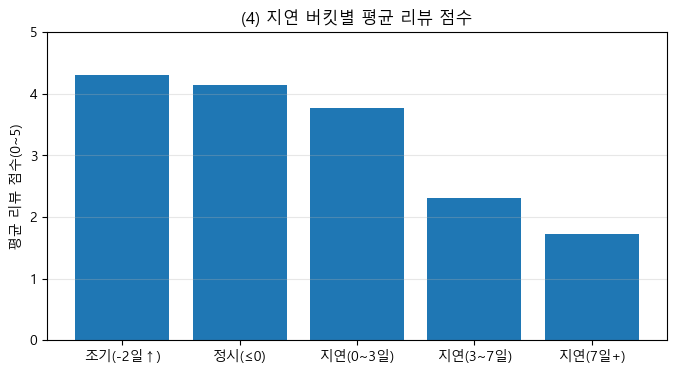

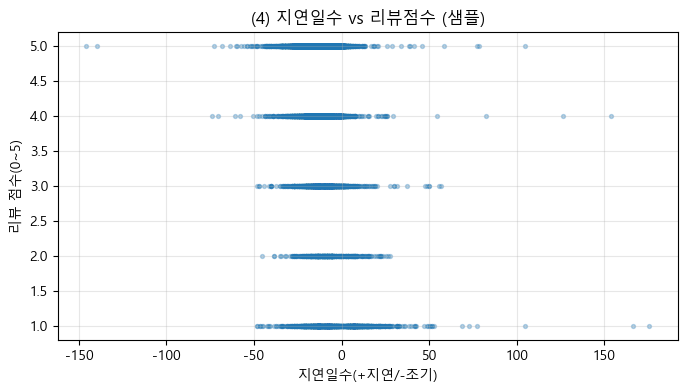


=== 요약 ===
- 전체 평균 리드타임: 12.56일, 정시율: 91.9%
- 권역 중 느린 곳(Top1): North / 평균 22.59일
- 정시율이 낮은 주(Top1): AL / 정시율 76.1%
- 리뷰 점수와 지연의 상관(음수일수록 만족↑, 양수일수록 만족↓ 경향) 및 버킷별 점수 차이를 확인하세요.


In [10]:
# -------------------------------------------------
# (4) 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향
# -------------------------------------------------
rev = reviews[['order_id','review_score','review_creation_date']].copy()
rev['review_creation_date'] = pd.to_datetime(rev['review_creation_date'], errors='coerce')

ship_rev = ship.merge(rev, on='order_id', how='left')
ship_rev = ship_rev[ship_rev['review_score'].notna()].copy()

# 단순 상관 / 집단 비교
corr = ship_rev[['delay_days','t_purchase_to_delivered','review_score']].corr().loc['review_score']
print("\n=== (4) 리뷰 점수와의 상관(피어슨) ===")
display(corr.to_frame('상관계수').round(3))

# 지연 버킷 생성
bins = [-999, -2, 0, 3, 7, 999]  # 조기/정시/경미지연/중간/중대
labels = ['조기(-2일↑)','정시(≤0)','지연(0~3일)','지연(3~7일)','지연(7일+)']
ship_rev['delay_bucket'] = pd.cut(ship_rev['delay_days'], bins=bins, labels=labels, include_lowest=True)

bucket_score = (ship_rev
    .groupby('delay_bucket')
    .agg(리뷰수=('review_score','count'),
         평균점수=('review_score','mean'),
         중위점수=('review_score','median'))
    .reset_index()
)
print("=== (4) 지연 버킷별 리뷰 점수 ===")
display(bucket_score.round(2))

# 시각화: 버킷별 평균 리뷰 점수
plt.figure(figsize=(8,4))
plt.bar(bucket_score['delay_bucket'].astype(str), bucket_score['평균점수'])
plt.title("(4) 지연 버킷별 평균 리뷰 점수")
plt.ylim(0,5); plt.ylabel("평균 리뷰 점수(0~5)")
plt.grid(axis='y', alpha=0.3); plt.show()

# 시각화: 지연일수 vs 리뷰점수 산포(표본)
sample = ship_rev.sample(min(15000, len(ship_rev)), random_state=42)
plt.figure(figsize=(8,4))
plt.scatter(sample['delay_days'], sample['review_score'], s=8, alpha=0.3)
plt.title("(4) 지연일수 vs 리뷰점수 (샘플)")
plt.xlabel("지연일수(+지연/-조기)"); plt.ylabel("리뷰 점수(0~5)")
plt.grid(alpha=0.3); plt.show()

# -------------------------------------------------
# 간단 요약 프린트
# -------------------------------------------------
print("\n=== 요약 ===")
print(f"- 전체 평균 리드타임: {summary_overall['리드타임_평균(일)'].iloc[0]:.2f}일, 정시율: {summary_overall['정시율(%)'].iloc[0]:.1f}%")
print(f"- 권역 중 느린 곳(Top1): {slow_regions.iloc[0]['customer_region']} / 평균 {slow_regions.iloc[0]['리드타임_평균']:.2f}일")
print(f"- 정시율이 낮은 주(Top1): {risk_states.iloc[0]['customer_state']} / 정시율 {risk_states.iloc[0]['정시율']:.1f}%")
print("- 리뷰 점수와 지연의 상관(음수일수록 만족↑, 양수일수록 만족↓ 경향) 및 버킷별 점수 차이를 확인하세요.")